<center><h1> GEARS Dataset </h1></center>

## Context

This notebook intend to load the dataset used in GEARS and in the benchmarking paper [\[1\]](#benchmark).

In particular, we will be using the following [datasets](#datasets).

## Table of Contents

- [Raw Data](#raw-pipeline)
- [Pre-processed Data](#pre-processed-pipeline)

## Datasets

### Raw Data

- [Adamson](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE90546): 
  - ht<span>tps://</span>www.ncbi.nlm.nih.gov/geo/download/?acc=GSE90546&format=file
  - Assay type: perturb-seq: a combination of droplet based scRNAseq with a strategy for barcoding CRISPR-mediated perturbations.
  - Single CRIPSRi perturbation.
  - Overall: 3 different pooled CRIPSR screening experiments were conducted via perturb-seq.
- [Replogle](https://plus.figshare.com/articles/dataset/_Mapping_information-rich_genotype-phenotype_landscapes_with_genome-scale_Perturb-seq_Replogle_et_al_2022_processed_Perturb-seq_datasets/20029387):
  - Single cell raw **K562 genome scale scale day 8 post-transduction** ht<span>tps://</span>plus.figshare.com/ndownloader/files/35775507
  - Single cell raw **K562 essential scale day 6 post-transduction** ht<span>tps://</span>plus.figshare.com/ndownloader/files/35773219
  - Single cell raw **RPE1 essential scale  day 7 post-transduction** ht<span>tps://</span>plus.figshare.com/ndownloader/files/35775606
- [Norman](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133344):
  - raw_barcodes.tsv.gz: ht<span>tps://</span>ftp.ncbi.nlm.nih.gov/geo/series/GSE133nnn/GSE133344/suppl/GSE133344%5Fraw%5Fbarcodes.tsv.gz
  - raw_cell_identities.csv.gz: ht<span>tps://</span>ftp.ncbi.nlm.nih.gov/geo/series/GSE133nnn/GSE133344/suppl/GSE133344%5Fraw%5Fcell%5Fidentities.csv.gz
  - raw_genes.tsv.gz: ht<span>tps://</span>ftp.ncbi.nlm.nih.gov/geo/series/GSE133nnn/GSE133344/suppl/GSE133344%5Fraw%5Fgenes.tsv.gz
  - raw_matrix.mtx.gz: ht<span>tps://</span>ftp.ncbi.nlm.nih.gov/geo/series/GSE133nnn/GSE133344/suppl/GSE133344%5Fraw%5Fmatrix.mtx.gz

### Pre-processed Data
For completeness, here are the datasets used by GEARS or scFoundation and the benchmarking paper [\[1\]](#benchmark).

**GEARS**:

- Single-gene perturbation:
  - [Adamson](https://dataverse.harvard.edu/file.xhtml?fileId=6154417&version=3.0&toolType=PREVIEW): ht<span>tps://</span>dataverse.harvard.edu/api/access/datafile/6154417
  - [Relogle K562](https://dataverse.harvard.edu/file.xhtml?fileId=7458695&version=6.0&toolType=PREVIEW): ht<span>tps://</span>dataverse.harvard.edu/api/access/datafile/7458695
  - [Replogle RPE1](https://dataverse.harvard.edu/file.xhtml?fileId=7458694&version=6.0&toolType=PREVIEW): ht<span>tps://</span>dataverse.harvard.edu/api/access/datafile/7458694

- Multiple-gene perturbation
  - [Norman](https://dataverse.harvard.edu/file.xhtml?fileId=6154020&version=3.0&toolType=PREVIEW): ht<span>tps://</span>dataverse.harvard.edu/api/access/datafile/6154020
  - 131 two-gene perturbations

**scFoundation**:

Another preprocessing strategy for the Norman et al. dataset
- [Norman scFoundation](https://figshare.com/articles/dataset/scFoundation_Large_Scale_Foundation_Model_on_Single-cell_Transcriptomics_-_processed_datasets/24049200?file=44477939): ht<span>tps://</span>figshare.com/ndownloader/files/44477939
## References

1. Ahlmann-Eltze, Huber, and Anders, “Deep Learning-Based Predictions of Gene Perturbation Effects Do Not yet Outperform Simple Linear Baselines.”<a id="benchmark"></a>


## 1) Download Datasets

Note that the bash script is run from the Notebook but you can also run it from the shell. File will be downloaded using the `yaml` config in `fine_tune/config/download.yaml`.

In [ ]:
%%bash
cd ../../../ # cd to root of the project
python fine_tune/scripts/download/cli.py --config fine_tune/config/download.yaml

## 2) Create AnnData From Raw

In [1]:
# All imports here
from pathlib import Path

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import median_abs_deviation

data_path = Path("./../../datasets")


%reload_ext autoreload
%autoreload 2


### a) Adamson
**Note on Adamson**

- GSM2406675_10X001: **Pilot Experiment**
  - 
- GSM2406677_10X005: **UPR (unfolded protein response) Epistasis Experiment**
- GSM2406681_10X010: **UPR Perturb-seq Experiment**
  

In [244]:
adamson_dir = data_path.joinpath("raw/raw_adamson")
mtx_files = sorted(adamson_dir.glob("*_matrix.mtx.txt.gz"))

all_adatas = {}

for mtx_file in mtx_files:
    prefix = mtx_file.name.split("_matrix")[0]

    # Paths
    barcodes_file = adamson_dir / f"{prefix}_barcodes.tsv.gz"
    genes_file = adamson_dir / f"{prefix}_genes.tsv.gz"
    identities_file = adamson_dir / f"{prefix}_cell_identities.csv.gz"

    # Load metadata
    genes = pd.read_csv(genes_file, header=None, sep="\t")
    barcodes = pd.read_csv(barcodes_file, header=None)
    cell_identities = pd.read_csv(identities_file, index_col=0)

    # Create AnnData
    adata = ad.io.read_mtx(mtx_file).T
    adata.var_names = genes[0].values
    adata.obs_names = barcodes[0].values
    # adata.obs = cell_identities.loc[adata.obs_names] fail because more barcodes than cell_identity.
    adata.obs = pd.DataFrame(index=adata.obs_names)
    adata.obs = adata.obs.join(cell_identities) # fill with NaN barcodes with non found identity

    # Optional: keep track of the experiment
    adata.obs["experiment"] = prefix
    all_adatas[prefix] = adata

all_adatas

{'GSM2406675_10X001': AnnData object with n_obs × n_vars = 5768 × 35635
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment',
 'GSM2406677_10X005': AnnData object with n_obs × n_vars = 15006 × 32738
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment',
 'GSM2406681_10X010': AnnData object with n_obs × n_vars = 65337 × 32738
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment'}

In [ ]:
adata_adamson = ad.concat(all_adatas, axis="obs", join="outer", index_unique="_")

In [298]:
all_adatas["GSM2406677_10X005"].obs["guide identity"].value_counts(dropna=False).iloc[-(115-80):] # / 15006

guide identity
3x_neg_ctrl_pMJ144-1     1726
ATF6_PERK_IRE1_pMJ158    1709
ATF6_only_pMJ145         1704
IRE1_only_pMJ148         1695
3x_neg_ctrl_pMJ144-2     1661
PERK_IRE1_pMJ154         1642
ATF6_PERK_pMJ150         1609
PERK_only_pMJ146         1571
ATF6_IRE1_pMJ152         1459
NaN                       194
*                          14
PSMD12_pDS009               6
PSMA1_pDS007                4
IER3IP1_pDS003              3
XBP1_pBA578                 2
C7orf26_pDS004              2
ATF4_pBA576                 1
SNAI1_pDS266                1
XBP1_pBA579                 1
Gal4-4(mod)_pBA582          1
YIPF5_pDS001                1
Name: count, dtype: int64

#### i) Formatting Adamson

Add more metadata:
- `gene_name`
- parse `guide identity`:
  - `target`
  - `plasmid`
- original `cell_barcode`
- add `cell_type` (using the paper)
  individually transduced chronic myeloid leukemia cells (K562)
  
    | **Experimental Models: Cell Lines** | 
    | - |
    | cBA010 (K562 UPRE reporter cell line, parental) |
    | cBA011 (cBA010 stably transduced with pBA409) |
    | GFP+ K562 dCas9-KRAB cell line  |
    | cMJ006 (GFP+ K562 dCas9-KRAB cell line stably transduced with pMH0001) |


In [ ]:
annot37 = sc.queries.biomart_annotations(
    org="hsapiens",
    attrs=["ensembl_gene_id", "external_gene_name"],
    host="grch37.ensembl.org"
).set_index("ensembl_gene_id")

In [ ]:
adata_adamson.var["gene_name"] = annot37.loc[adata_adamson.var_names]

#### Parse target and plasmid from guide identity

In [ ]:
map_guide_id = {
    g: {"target": "_".join(g_split[:-1]),
        "plasmid":  g_split[-1]}
        for g in adata_adamson.obs["guide identity"].unique().astype(str)
        if (_g_split := g.split("_")) and
           (g_split := _g_split if len(_g_split) > 1 else _g_split * 2)
}

In [ ]:
adata_adamson.obs = adata_adamson.obs.join(
    adata_adamson.obs["guide identity"].astype(str).to_frame().join(
        pd.DataFrame(map_guide_id).T,
        on="guide identity"
    ).drop(columns=["guide identity"])
)

#### Get original barcode

In [ ]:
adata_adamson.obs["cell_barcode"] = adata_adamson.obs_names.to_series().str.split("_").apply(lambda split: split[0])

### c) Why not to use Gears Adamson

In [246]:
gears_adamson = ad.read_h5ad(next((data_path / "anndata/gears_adamson").glob("*.h5ad")))
print(gears_adamson,"\n")
print(gears_adamson.obs.to_string())

AnnData object with n_obs × n_vars = 68603 × 5060
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20' 

                        condition cell_type dose_val  control             condition_name
cell_barcode                                                                            
AAACATACACCGAT-1       CREB1+ctrl   K562(?)      1+1        0     K562(?)_CREB1+ctrl_1+1
AAACATACAGAGAT-1             ctrl   K562(?)        1        1             K562(?)_ctrl_1
AAACATACCAGAAA-1             ctrl   K562(?)        1        1             K562(?)_ctrl_1
AAACATACGTTGAC-1             ctrl   K562(?)        1        1             K562(?)_ctrl_1
AAACATACTGTTCT-1             ctrl   K562(?)        1        1             K562(?)_ctrl_1
AAACCGTGCAGCTA-1      ZNF326+ctrl   K562(?)      1+1        0    K562(?)_ZNF326+ctrl_1+1
AAACCGTGCC

#### Get condition from gears

In [252]:
adata_adamson_not_gears = adata_adamson[(~adata_adamson.obs["cell_barcode"].isin(gears_adamson.obs_names))].copy()
adata_adamson_gears = adata_adamson[(adata_adamson.obs["cell_barcode"].isin(gears_adamson.obs_names))].copy()
adata_adamson_gears.obs = adata_adamson_gears.obs.join(
    gears_adamson.obs["condition"].str.split("+").apply(lambda cond: cond[0]),
    on="cell_barcode"
).rename(columns={"condition": "gears_condition"})

In [253]:
gears_adamson.obs

condition cell_type dose_val  control  \
cell_barcode                                                   
AAACATACACCGAT-1      CREB1+ctrl   K562(?)      1+1        0   
AAACATACAGAGAT-1            ctrl   K562(?)        1        1   
AAACATACCAGAAA-1            ctrl   K562(?)        1        1   
AAACATACGTTGAC-1            ctrl   K562(?)        1        1   
AAACATACTGTTCT-1            ctrl   K562(?)        1        1   
...                          ...       ...      ...      ...   
TTTGCATGCTTTAC-10     STT3A+ctrl   K562(?)      1+1        0   
TTTGCATGGAGGAC-10  ARHGAP22+ctrl   K562(?)      1+1        0   
TTTGCATGTAGAGA-10           ctrl   K562(?)        1        1   
TTTGCATGTCAAGC-10    KCTD16+ctrl   K562(?)      1+1        0   
TTTGCATGTGGAGG-10    SAMM50+ctrl   K562(?)      1+1        0   

                              condition_name  
cell_barcode                                  
AAACATACACCGAT-1      K562(?)_CREB1+ctrl_1+1  
AAACATACAGAGAT-1              K562(?)_ctrl_1  
AAACATACCAGAAA-1              K562(?)_ctrl_1  
AAACATACGTTGAC-1              K562(?)_ctrl_1  
AAACATACTGTTCT-1              K562(?)_ctrl_1  
...                                      ...  
TTTGCATGCTTTAC-10     K562(?)_STT3A+ctrl_1+1  
TTTGCATGGAGGAC-10  K562(?)_ARHGAP22+ctrl_1+1  
TTTGCATGTAGAGA-10             K562(?)_ctrl_1  
TTTGCATGTCAAGC-10    K562(?)_KCTD16+ctrl_1+1  
TTTGCATGTGGAGG-10    K562(?)_SAMM50+ctrl_1+1  

[68603 rows x 5 columns]

In [254]:
mismatch = (
    adata_adamson_gears[
        adata_adamson_gears.obs["target"] != adata_adamson_gears.obs["gears_condition"]
    ].obs[["target", "gears_condition"]]
    .groupby(["target", "gears_condition"])
    .size().unstack(fill_value=0)
)
mismatch["ctrl"][mismatch["ctrl"] > 100]


target
3x_neg_ctrl       3124
62(mod)           1655
63(mod)           4599
ASCC3              959
ATF6_IRE1         1326
ATF6_PERK         1456
ATF6_PERK_IRE1    1542
ATF6_only         1549
DNAJC19            831
EP300              561
IRE1_only         1550
PERK_IRE1         1511
PERK_only         1422
SEC61B            1003
SNAI1              527
SPI1               645
Name: ctrl, dtype: int64

In [255]:
# adata_adamson[~adata_adamson.obs["experiment"].isin(["GSM2406681_10X010"])].obs["target"].unique()
count_vs_mismatch = adata_adamson_gears.obs["target"].value_counts().to_frame().join(
    pd.Series(mismatch.sum(axis=1), name="mismatch")).dropna()
count_vs_mismatch["percentage"] = (100 * count_vs_mismatch["mismatch"] / count_vs_mismatch["count"]).round(1)
adata_adamson_gears.obs = adata_adamson_gears.obs.join(
    count_vs_mismatch,
    on="target"
)

In [256]:
adata_adamson_gears.obs = adata_adamson_gears.obs.join(
    pd.Series(adata_adamson_gears.obs["experiment"].value_counts(), name="tot_count_by_experiment"),
    on="experiment"
)

In [257]:
adata_adamson_gears.obs = adata_adamson_gears.obs.join(
    (adata_adamson_gears.obs[["mismatch", "experiment"]].drop_duplicates()
     .groupby(["experiment"]).sum()
     .rename(columns={"mismatch": "tot_mismatch"})),
    on="experiment"
)

In [258]:
adata_adamson_gears.obs["percentage_tot_mismatch_by_experiment"] = (
    100 * adata_adamson_gears.obs["tot_mismatch"] / adata_adamson_gears.obs["tot_count_by_experiment"]
).round(1)

In [259]:
gears_adamson

AnnData object with n_obs × n_vars = 68603 × 5060
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [260]:
adata_adamson_gears

AnnData object with n_obs × n_vars = 68663 × 35635
    obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment', 'target', 'plasmid', 'cell_barcode', 'gears_condition', 'count', 'mismatch', 'percentage', 'tot_count_by_experiment', 'tot_mismatch', 'percentage_tot_mismatch_by_experiment'
    var: 'gene_name'

In [261]:
adata_adamson_gears.obs[["percentage_tot_mismatch_by_experiment", "experiment"]].drop_duplicates()

percentage_tot_mismatch_by_experiment  \
AAACATACACCGAT-1_GSM2406675_10X001                                   63.7   
AAACATACACTCAG-1_GSM2406677_10X005                                  100.0   
AAACATACAAGATG-1_GSM2406681_10X010                                   14.9   

                                           experiment  
AAACATACACCGAT-1_GSM2406675_10X001  GSM2406675_10X001  
AAACATACACTCAG-1_GSM2406677_10X005  GSM2406677_10X005  
AAACATACAAGATG-1_GSM2406681_10X010  GSM2406681_10X010

In [262]:
adata_adamson_gears.obs[adata_adamson_gears.obs["percentage"] > 5].groupby(["experiment", "target"]).size().unstack(fill_value=0)

target             *  3x_neg_ctrl  62(mod)  63(mod)  ASCC3  ATF6_IRE1  \
experiment                                                              
GSM2406675_10X001  0            0     1655        0      0          0   
GSM2406677_10X005  0         3127        0        0      0       1328   
GSM2406681_10X010  1            0        0     4600   1482          0   

target             ATF6_PERK  ATF6_PERK_IRE1  ATF6_only  DNAJC19  EP300  \
experiment                                                                
GSM2406675_10X001          0               0          0        0    561   
GSM2406677_10X005       1459            1546       1553        0      0   
GSM2406681_10X010          0               0          0     1276      0   

target             Gal4-4(mod)  IRE1_only  PERK_IRE1  PERK_only  SEC61B  \
experiment                                                                
GSM2406675_10X001            0          0          0          0       0   
GSM2406677_10X005            0       1552       1516       1425       0   
GSM2406681_10X010            7          0          0          0    1429   

target             SNAI1  SPI1  nan  
experiment                           
GSM2406675_10X001    527   646    0  
GSM2406677_10X005      0     0    3  
GSM2406681_10X010      0     0    0

### Raw Norman

In [ ]:
# Define paths
norman_dir = data_path.joinpath("raw/raw_norman")

# Load gene and barcode names
genes = pd.read_csv(norman_dir / "genes.tsv.gz", header=None, sep="\t")
barcodes = pd.read_csv(norman_dir / "barcodes.tsv.gz", header=None)

# Load cell identities
cell_identities = pd.read_csv(norman_dir / "cell_identities.csv.gz", index_col=0)

# Build AnnData
adata_norman = ad.io.read_mtx(norman_dir / "matrix.mtx.gz").T
adata_norman.var_names = genes[0].values
adata_norman.obs_names = barcodes[0].values
# adata.obs = cell_identities.loc[adata.obs_names] fail because more barcodes than cell_identity.
adata_norman.obs = pd.DataFrame(index=adata_norman.obs_names)
adata_norman.obs = adata_norman.obs.join(cell_identities) # fill with NaN barcodes with non found identity

## Filtering

**Quality Control:**

- Mitochondrial genes
- Ribosomal genes
- hemoglobin genes

**Doublet Detection:**

# Test PCA

In [6]:
all_adatas["GSM2406675_10X001"].obs["guide identity"].unique()

array(['CREB1_pDS269', 'SNAI1_pDS266', '62(mod)_pBA581', 'EP300_pDS268',
       'ZNF326_pDS262', 'BHLHE40_pDS258', 'SPI1_pDS255', 'DDIT3_pDS263',
       nan, '*'], dtype=object)

In [4]:
all_adatas

{'GSM2406675_10X001': AnnData object with n_obs × n_vars = 5768 × 35635
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment',
 'GSM2406677_10X005': AnnData object with n_obs × n_vars = 15006 × 32738
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment',
 'GSM2406681_10X010': AnnData object with n_obs × n_vars = 65337 × 32738
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment'}

In [7]:
adata = all_adatas["GSM2406681_10X010"].copy()

In [10]:
adata.var["gene_name"] = annot37.loc[adata.var_names]
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var["gene_name"].str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var["gene_name"].str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var["gene_name"].str.contains("^HB[^(P)]")

In [11]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], percent_top=[20], inplace=True, log1p=True
)

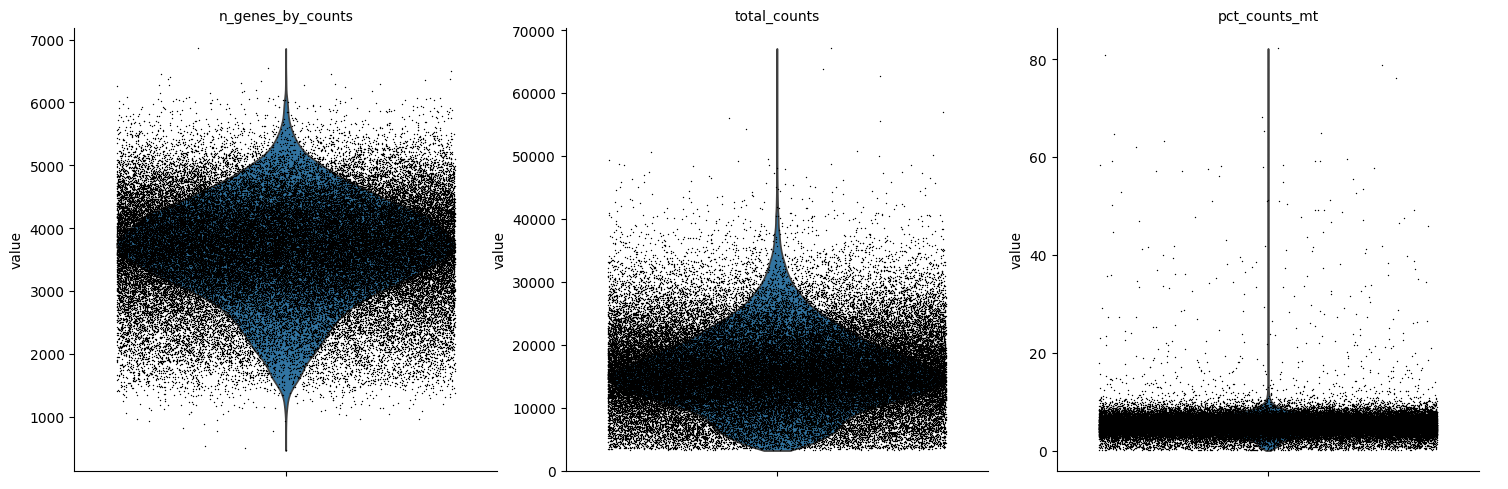

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],#, "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

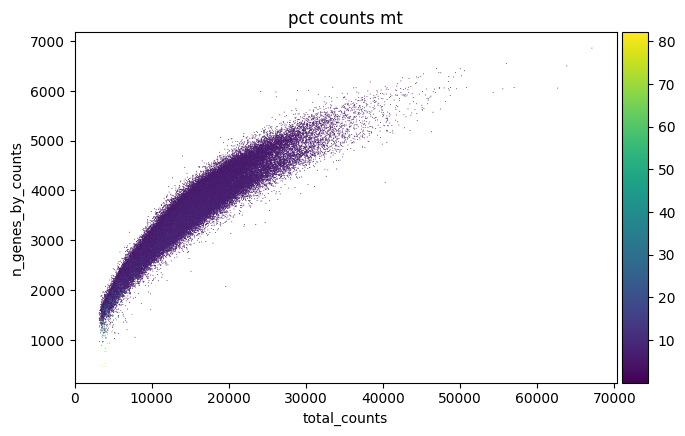

In [13]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [14]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [15]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print(adata.obs.outlier.value_counts())

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
print(adata.obs.mt_outlier.value_counts())

outlier
False    63318
True      2019
Name: count, dtype: int64
mt_outlier
False    59687
True      5650
Name: count, dtype: int64


In [16]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 65337


Number of cells after filtering of low quality cells: 58544


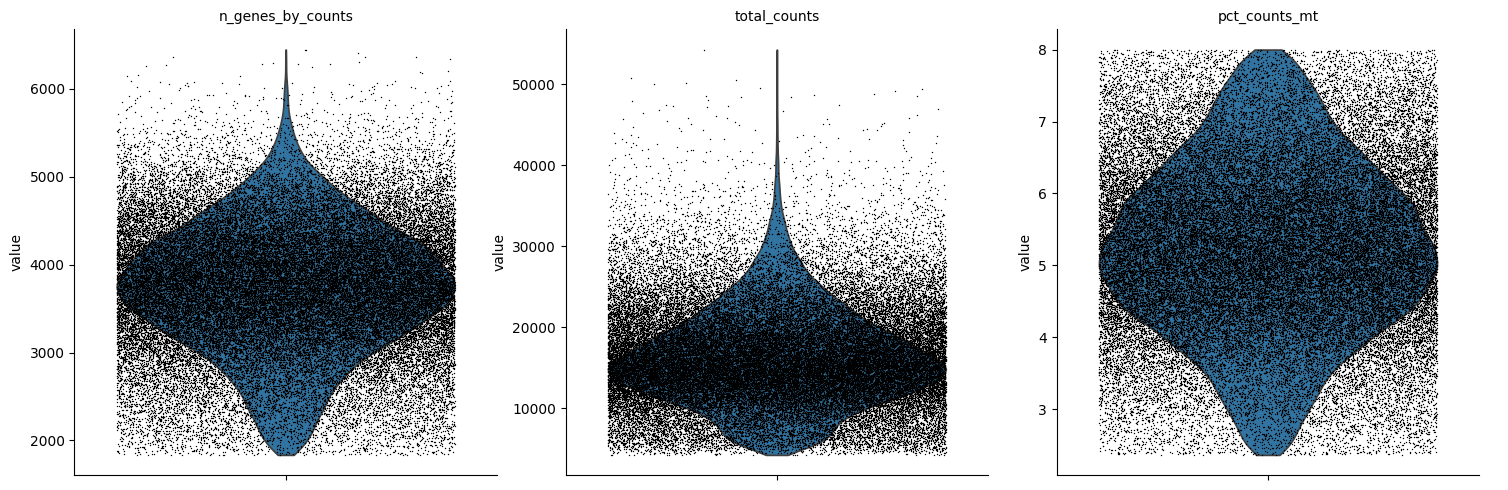

In [17]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],#, "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

In [18]:
sc.pp.filter_genes(adata, min_cells=20)

In [19]:
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


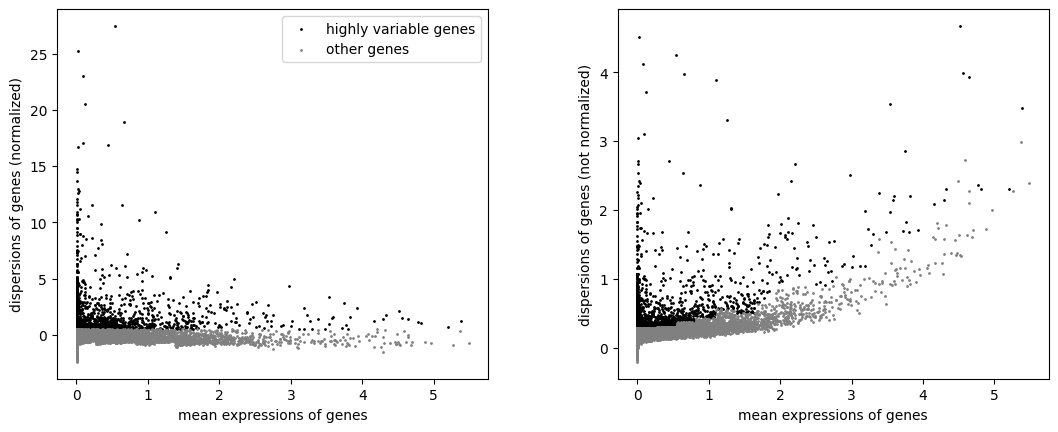

In [21]:
sc.pl.highly_variable_genes(adata)

In [22]:
sc.tl.pca(adata)

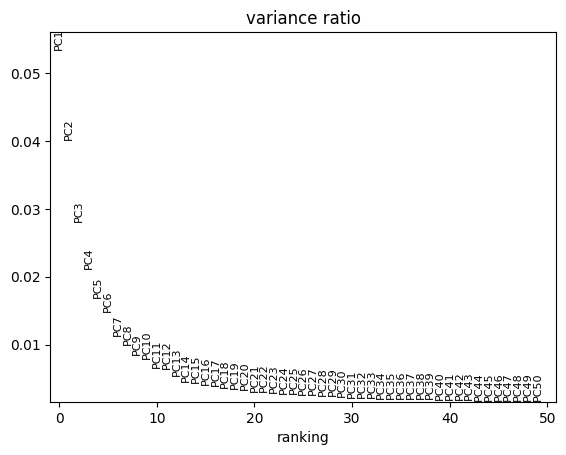

In [23]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=False)

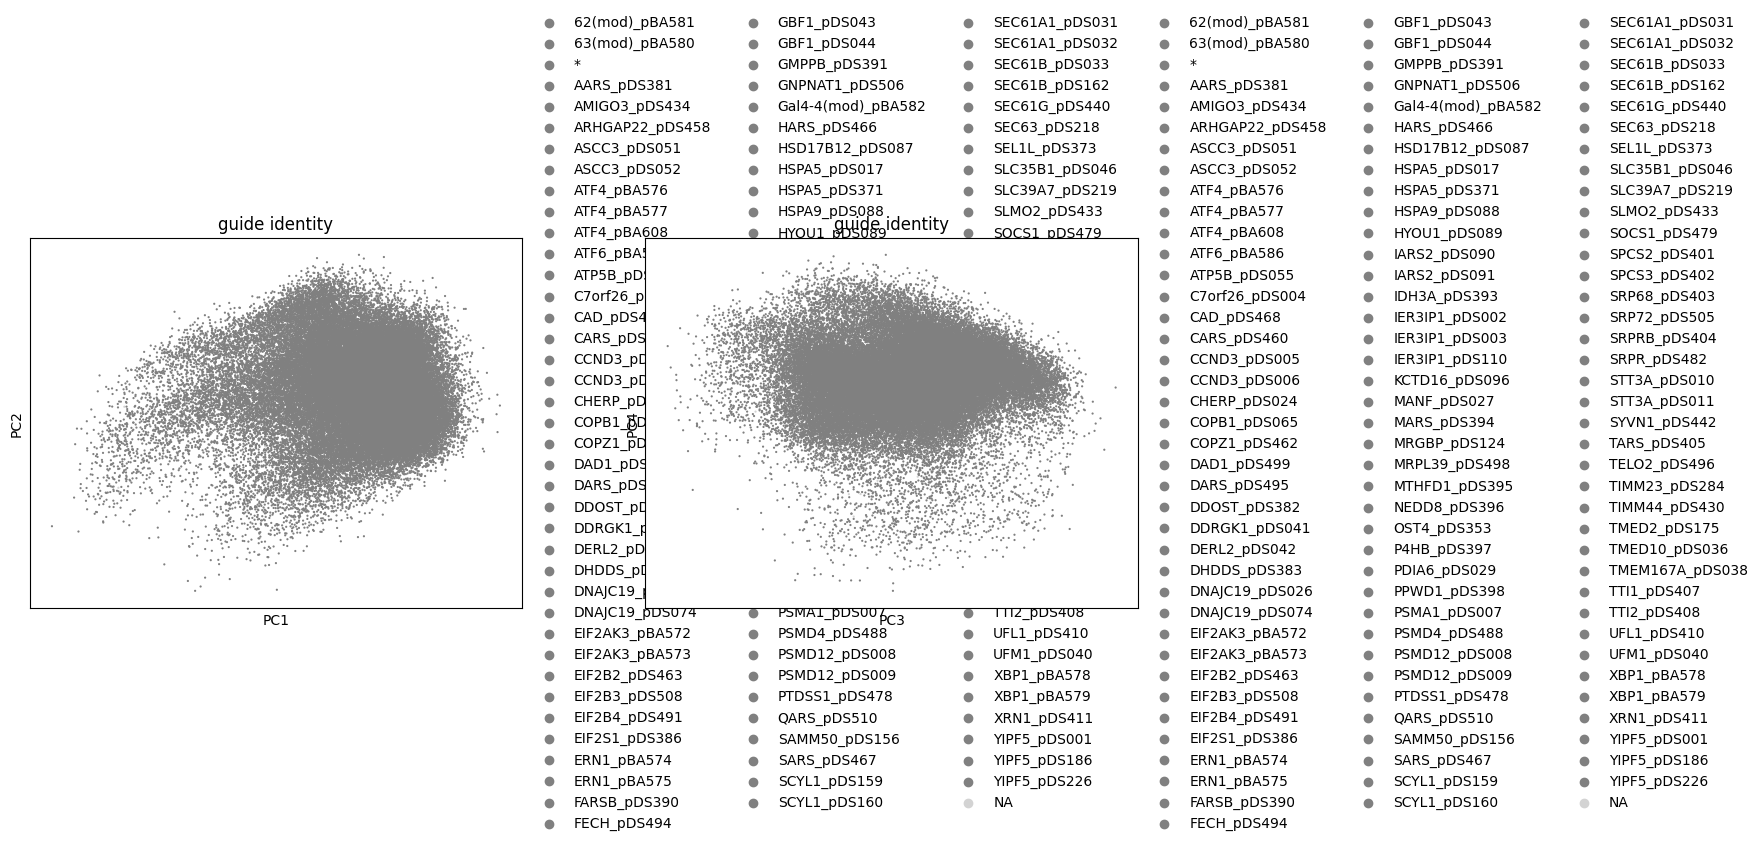

In [24]:
sc.pl.pca(
    adata,
    color=["guide identity", "guide identity"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=10,
)

In [25]:
adata

AnnData object with n_obs × n_vars = 58544 × 16900
    obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'guide identity_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [26]:
sc.pp.neighbors(adata)

In [27]:
sc.tl.umap(adata)

In [271]:
adata

AnnData object with n_obs × n_vars = 5649 × 11970
    obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'guide identity_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

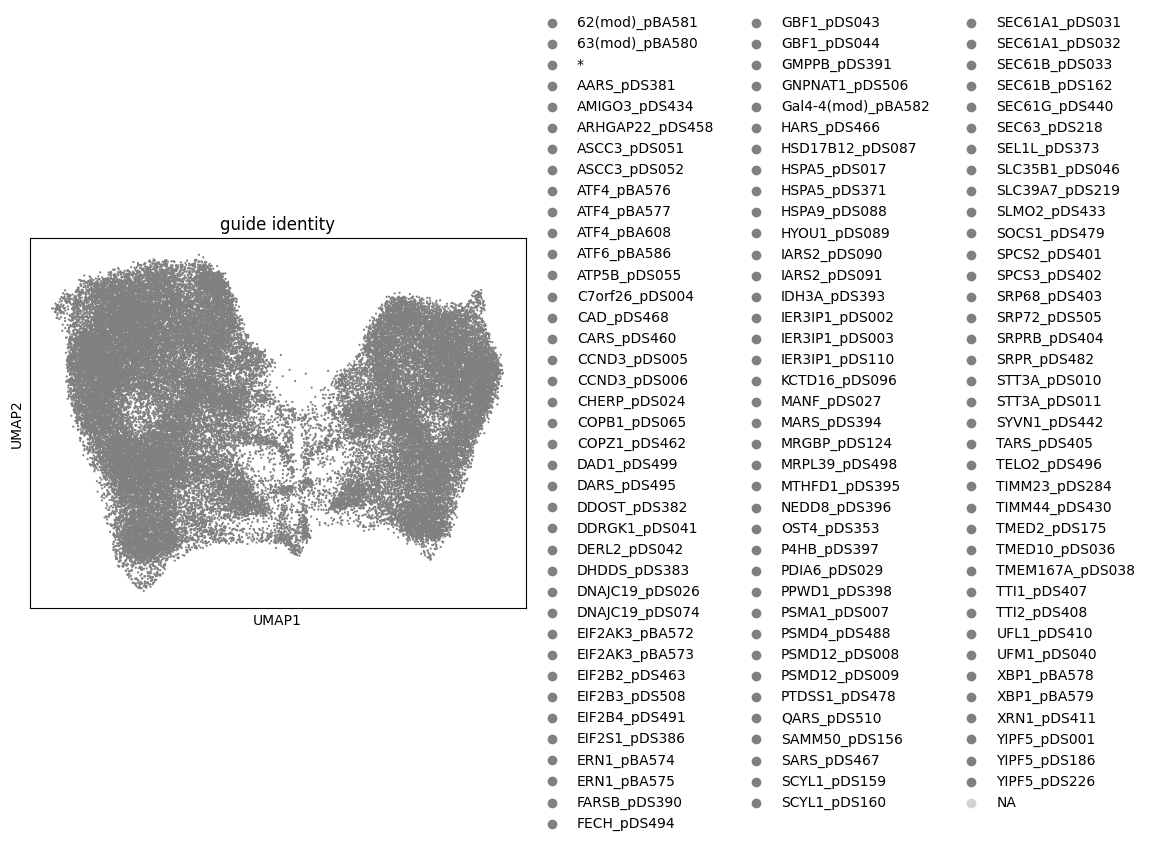

In [ ]:
sc.pl.umap(
    adata,
    color="guide identity",
    # Setting a smaller point size to get prevent overlap
    size=10,
)